#Deep Learning Tools Tutorial -- Teeth Segmentation (DL-Fall23)

Developed by: Ping-Cheng Ku (pku1@jh.edu)

### Setup

In [ ]:
!pip install datasets  # This is for HuggingFace
!pip install wandb # Weight-and-Bias
!pip install tensorflow-addons # Tensorflow addons

## Import packages

In [ ]:
from datasets import load_dataset, DatasetDict  # This is the package for huggingface
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import tensorflow_addons as tfa

# Understanding the dataset

###Fully understand the data you are working with is an essential step before training any deep learning models. It provides insights on:

-**Identifying outliers**: It is possible that your dataset contains a lot of outliers, which you may want to try to remove them as a part of preprocessing process.

-**Make model decisions**: You should choose/adjust your model based on the data you are working with. What are the goals that we want to achieve and what blocks should we use (convolution blocks/recurrent blocks/ attention mechanism)? How deep (# of parameters) should the model be so that it will train well without overfitting?

-**What preprocessing steps to be run**: Based on the give dataset, you should decide whether you should standardize the data and how you should split the data. You need to determine whether reasonable to perform data auagmentation, and what augmentation should be included in the training dataset? If there are class-imbalances for a classification task, you might want to run data augmentation to balance the clesses. If there are artifacts in images, you might also want to remove them in the preprocessing step.

### We will be using the dataset SegmentationOfTeethPanoramicXRayImages for this tutorial. The dataset is hosted on Huggingface and we will use its API to preprocess the dataset. The original dataset can be found here:
https://huggingface.co/datasets/SerdarHelli/SegmentationOfTeethPanoramicXRayImages

An example image should be like this:
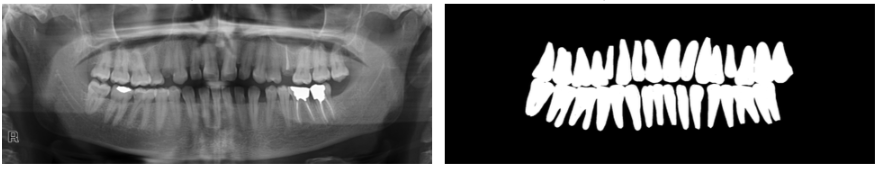

In [ ]:
dataset = load_dataset("SerdarHelli/SegmentationOfTeethPanoramicXRayImages")

In [ ]:
print(dataset)

Dataset could be orgnaized differently for different projects. In Huggingface, datasets are stored in DatasetDict objects. You may check out more about dataset preprocessing here: https://huggingface.co/docs/datasets/access

After further inspection of the dataset, we realize that there is only training dataset under DatasetDict. This is also likely to happen in your project if you are given a raw dataset of images/data. We will perform the relative splits and visualize the data:

In [ ]:
# dataset = load_dataset("SerdarHelli/SegmentationOfTeethPanoramicXRayImages")
train_dataset = dataset['train'].train_test_split(test_size=0.1, seed=42)
new_dataset = DatasetDict({
    'train': train_dataset['train'],
    'validation': train_dataset['test']
})

print(new_dataset)

###Lets try to visualize the segmentation task:


In [ ]:
n_samples = 3

indices = np.random.choice(len(new_dataset['train']), size=n_samples, replace=False)

print(indices)

fig, axs = plt.subplots(n_samples, 2, figsize=(10, 10))

for i, idx in enumerate(indices):

    image = np.array(new_dataset['train'][int(idx)]['image'])
    label = np.array(new_dataset['train'][int(idx)]['label'])

    axs[i, 0].imshow(image, cmap='gray')
    axs[i, 0].set_title(f"Sample {i+1} - Data")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(label, cmap='gray')
    axs[i, 1].set_title(f"Sample {i+1} - Ground Truth")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

### Histograms help visualize the distribution of the training data and help us spot if the given dataset contains outliers. (this may take some time)

In [ ]:
images = []
labels = []
n_sample = 3
indices = random.sample(range(0, new_dataset['train'].num_rows-1), n_sample)
print(indices)

all_image_values = []
all_label_values = []

for id in indices:
    sample = new_dataset['train'][id]
    image_array = np.array(sample['image'])
    label_array = np.array(sample['label'])
    print(f"image_shape: ({image_array.shape[0], image_array.shape[1]})")

    all_image_values.extend(image_array.flatten())
    all_label_values.extend(label_array.flatten())

print('-'*8)
print(f"Max image pixel value: {np.max(all_image_values)}")
print(f"Min image pixel value: {np.min(all_image_values)}")
print(f"Mean image pixel value: {np.mean(all_image_values)}")
print(f"Image standard deviation: {np.std(all_image_values)}")
print('-'*8)
print(f"Max label pixel value: {np.max(all_label_values)}")
print(f"Min label pixel value: {np.min(all_label_values)}")
print(f"Mean label pixel value: {np.mean(all_label_values)}")
print(f"Label standard deviation: {np.std(all_label_values)}")

plt.hist(all_image_values, bins=50, color='blue', alpha=0.7, label='Images')
plt.title('Histogram of pixel values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.hist(all_label_values, bins=50, color='blue', alpha=0.7, label='Images')
plt.title('Histogram of pixel values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### By looking at the histograms, we quickly realize that the ground truth segmentation labels for this task are labeled with values of 0 and 255 instead of 0 and 1, and it seems like there are intermediate values as well. 0 is black and 255 is white for the labels. This is usually okay as we will scale them accordingly. We also see that the image is 2D and not 3D. The mask is 2D.

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 64, 64  # Let's try to make it super simple for this demo
bs = 12

# On the fly data augmentation
def augment_image(image, label):

    # flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        label = tf.image.flip_up_down(label)

    # rotation
    k = tf.random.uniform(shape=(), minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)
    label = tf.image.rot90(label, k=k)

    # contrast & brightness
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)

    return image, label

def process_sample(sample, augment=True):
    image = tf.image.convert_image_dtype(sample['image'], dtype=tf.float32)
    label = tf.image.convert_image_dtype(sample['label'], dtype=tf.float32)

    image = tf.expand_dims(image, axis=-1)
    label = tf.expand_dims(label, axis=-1)

    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    label = tf.image.resize(label, [IMG_HEIGHT, IMG_WIDTH])

    # scale to 0 to 1
    image = image / 255.0
    label = label / 255.0

    # 3-channels are needed for many image-based models like MobileNet
    image = tf.repeat(image, repeats=3, axis=-1)

    # Apply augmentation (train dataset)
    if augment:
      image, label = augment_image(image, label)

    return image, label


def create_dataset(data_source):
    return tf.data.Dataset.from_generator(
        lambda: data_source,
        output_signature={
            'image': tf.TensorSpec(shape=(None, None), dtype=tf.float32),
            'label': tf.TensorSpec(shape=(None, None), dtype=tf.float32)
        })

train_dataset = create_dataset(new_dataset['train']).map(lambda x:  process_sample(x, augment=True), num_parallel_calls=tf.data.AUTOTUNE).batch(bs).prefetch(tf.data.AUTOTUNE)
val_dataset = create_dataset(new_dataset['validation']).map(lambda x:  process_sample(x, augment=False), num_parallel_calls=tf.data.AUTOTUNE).batch(bs).prefetch(tf.data.AUTOTUNE)

### Visualize the data again after preprocessing to ensure that the data augmentation and the maximum value of the data is correct.

In [ ]:
for images, labels in train_dataset.take(1):
    sample_images = images
    sample_labels = labels

print("Sample Image shape:", sample_images[0].shape)
print("Sample Label shape:", sample_labels[0].shape)

print("Sample Image Max value:", tf.reduce_max(sample_images[0]))
print("Sample Image Min value:", tf.reduce_min(sample_images[0]))

print("Sample Image Max value:", tf.reduce_max(sample_labels[0]))
print("Sample Image Min value:", tf.reduce_min(sample_labels[0]))


# Visualize training data
for train_images, train_labels in train_dataset.take(1):
    for idx in range(3):

      plt.figure(figsize=(15, 5))

      plt.subplot(1, 2, 1)
      plt.imshow(train_images[idx].numpy())
      plt.title('Train Image')

      plt.subplot(1, 2, 2)
      plt.imshow(train_labels[idx].numpy())
      plt.title('Ground Truth Label')

      plt.show()

In [ ]:
# Visualize validation data
for val_images, val_labels in val_dataset.take(1):
    for idx in range(3):

      plt.figure(figsize=(15, 5))

      plt.subplot(1, 2, 1)
      plt.imshow(val_images[idx].numpy())
      plt.title('Validation Image')

      plt.subplot(1, 2, 2)
      plt.imshow(val_labels[idx].numpy())
      plt.title('Ground Truth Label')

      plt.show()

### Let's try out DeepLabV3+ that was introduced in the flipped classroom

In [ ]:
!git clone https://github.com/lattice-ai/DeepLabV3-Plus
%cd /content/DeepLabV3-Plus

In [ ]:
from deeplabv3plus.model.deeplabv3_plus import DeeplabV3Plus
from tensorflow.keras.layers import Conv2D, Activation
from tensorflow.keras.models import Model
import wandb
import datetime
from wandb.keras import WandbCallback

In [ ]:
# This is the base DeepLabV3+ model
base_model = DeeplabV3Plus(backbone='resnet50', num_classes=1)

# Based on the documentation of DeeplabV3Plus, there is no activation in the final layer
# so we try to add one here for our task (binary segmentation)
input_layer = tf.keras.layers.Input(batch_shape=(bs, IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(input_layer)
output_layer = tf.keras.layers.Activation('sigmoid')(x)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Display the model summary
model.summary()

In [ ]:
# Tensorflow requires you to "complile" models before training
loss = tf.keras.losses.BinaryCrossentropy() # Binary segmentation
optimizer = tf.keras.optimizers.Adam() # Adam optimizer

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

### Here we start the training of our DeepLabV3+ model. We will be using 2 tools that I mentioned in course: WandB, and Tensorboard to keep track of the training performance. Note that this is an overkill as 1 visulization tool is usually enough.

In [ ]:
# Setting up a custom callback function for WandB visualization
class ImageWandbCallback(WandbCallback):
    def __init__(self, val_dataset, num_samples=3, **kwargs):
        super(ImageWandbCallback, self).__init__(**kwargs)
        self.val_dataset = val_dataset
        self.num_samples = num_samples

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for name, value in logs.items():
            if name in ['batch', 'size']:
                continue
            elif name in ['loss', 'val_loss']:
                wandb.log({name: value}, step=epoch)
            else:
                wandb.log({name: value}, step=epoch)

        for val_images, val_labels in self.val_dataset.take(1):
            preds = self.model.predict(val_images)
            for idx in range(self.num_samples):
                if idx == 0:
                  wandb.log({
                      f"Val Image {idx+1}": [wandb.Image(val_images[idx].numpy(), caption="Val Image")],
                      f"True Mask {idx+1}": [wandb.Image(val_labels[idx].numpy().squeeze(), caption="True Mask", mode='L')],
                      f"Pred Mask {idx+1}": [wandb.Image(preds[idx].squeeze(), caption="Pred Mask", mode='L')]
                  }, step=epoch)
        super().on_epoch_end(epoch, logs)

# You'll need to create an account on WandB (It's free and you can sign in with google)
# and paste your API key below when promted
wandb.init(project="DL_Fall23_teeth_seg_demo")

### Launch Tensorboard

In [ ]:
# It is possible that this may not load properly on Chrome. (The wandb loading will still work though)
%tensorboard --logdir logs/fit

### Main training loop

In [ ]:
# Train Tensorflow models using "model.fit", this may take a while without GPU
%load_ext tensorboard

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks_list = [tensorboard_callback, ImageWandbCallback(val_dataset, save_model=False)]

EPOCHS = 5 # Make it simple for the demo

print(f'Using device {tf.test.gpu_device_name()}.') # Tensorflow will automatically use GPU if detected

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=EPOCHS,
                    callbacks=callbacks_list)

wandb.finish()

## Visulaize outputs

In [ ]:
# training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

def plot_segmentation(image, true_mask, pred_mask):
    """Visualize image, true mask, and predicted mask."""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.tight_layout()
    plt.show()

# Show some samples
for val_images, val_labels in val_dataset.take(1):
    preds = model.predict(val_images)

    #pred_batch_binary = np.where(pred_batch > 0.5, 1, 0)

    for idx in range(3):
        plot_segmentation(val_images[idx], val_labels[idx], preds[idx].squeeze())